In [410]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import math
from random import *
from dateutil.parser import parse
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [411]:
dt_index = pd.DataFrame(pd.date_range(start='20110102', end='20191231')).rename(columns = {0 : 'date'})

def load_potato_price():
    print("======= data loading start ===========")
    conn = pymysql.connect(host='192.168.1.254', user='root', password='1234',
                           db='crawling', charset='utf8')
    curs = conn.cursor()
    sql = """
    SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date`
    FROM tbl_item WHERE tbl_item.`date` > '2011-01-01' and tbl_item.`품목` LIKE CONCAT('%' ,'%감자','%') 
    ORDER BY tbl_item.date ASC 
    """
    
    curs.execute(sql)
    rows = curs.fetchall()
    print("{}개의 데이터 로딩".format(len(rows)))
    data = pd.DataFrame(rows, columns=['name','now','before','date'])
    print(data.head(3))
    print("======= data loading finish ===========")
    print()
    return data

def potato_price_processing(data):
    print("======= data processing start ===========")
    print(data.shape)
    # 중복값 제거
    data = data.drop_duplicates()
       
    # before, now / string to int
    data['before'] = data['before'].apply(lambda x : int(x.replace(',','')))
    data['now'] = data['now'].apply(lambda x : int(x.replace(',','')))
    
    # name 통합
    data['name'] = data['name'].apply(lambda x : x.replace('감자(수미)', '감자 수미').replace('감자(대지마)', '감자 대지'))
    
    # 감자 수미 or 감자 대지 선택
    string = '감자 수미' # 감자 수미 or 감자 대지
    subdata = data[data['name'] == '감자 대지']
    data = data[data['name'] == string]
    
    # 20110101-20191231 인덱스 설정
    data['date'] = data['date'].apply(lambda x : parse(str(x)))
    data = pd.merge(dt_index, data, how = 'left', on = 'date').set_index('date')
    
    subdata['date'] = subdata['date'].apply(lambda x : parse(str(x)))
    subdata = pd.merge(dt_index, subdata, how = 'left', on = 'date').set_index('date')
    
    # name 통일
    data['name'] = string
    
    # null 값 채우기
    # 1) 0값을 null값으로
    def zero_to_nan(data):
        if math.isnan(data): return data
        elif data == 0: return np.nan
        else: return data

    data['before'] = data['before'].apply(zero_to_nan)
    data['now'] = data['now'].apply(zero_to_nan)
    
    # 2) now가 null 값일 때 다음날 before값이 존재할 때
    random_value = 10
    data['Fill_value'] = data.shift(-1)['before']
    data['now'] = data[['now', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['now']) else x['now'], axis = 1)
    
    # 3) 2014-04-01 ~ 2015-04-40 수미 감자 null 값을 대지 감자 price로 대체
    data['sub_now'] = subdata['now']
    data['tmp_date'] = data.index
    def fill_null_to_sub_now(data):
        if str(data['tmp_date']) > '2014-03-31' and str(data['tmp_date']) <= '2015-04-30': return data['sub_now']
        else: return data['now']
    data['now'] = data[['now','tmp_date','sub_now']].apply(fill_null_to_sub_now, axis = 1)
    
    # 4) 이전 날의 값으로 null값 대체
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill')
    
    # 불필요한 columns drop
    data.drop(['name','before','Fill_value','sub_now','tmp_date'],axis = 1,inplace = True)
    
    print(data.head())
    print(data.isnull().sum().sum())
    print(data.shape)
    print("======= data processing finish ===========")
    print()
    return data

In [412]:
def processing_Exchange_Rate(data):
    print('start')
    # 20110101부터 정렬
    data = data[::-1]
    # format datetime으로 변경
    data['날짜'] = data['날짜'].apply(lambda x : parse(x[:4] + x[6:8] + x[10:12]))
    # 20110101-20191231 인덱스 설정
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    print('전처리 전 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    # type 변경 str -> float
    data['종가'] = data['종가'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    data['오픈'] = data['오픈'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    
    # 주말 Null값 채우기
        
    # 일요일 : 월요일 오픈 가격으로 대체
    data['Fill_value'] = data.shift(-1)['오픈']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['종가']) else x['종가'], axis = 1)
    print('전처리 후 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    
    # 토요일 : 금요일 종가 + random value
    random_value = 3
    data['Fill_value'] = data.shift(1)['종가']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] + uniform(-random_value, random_value) if math.isnan(x['종가']) else x['종가'], axis = 1)

    data.drop(['날짜', '오픈', '고가', '저가', '변동 %', 'Fill_value'], axis = 1, inplace = True)    
                      
    print('전처리 후 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    
    print('end')
    return data

In [413]:
if __name__ == "__main__":
    print('감자 가격 전처리')
    potato_price = load_potato_price()
    potato_price= potato_price_processing(potato_price)
    
    print('환율 전처리')
    Exchange_Rate = processing_Exchange_Rate(pd.read_csv('USD_KRW.csv'))
    Exchange_Rate.head(5)

감자 가격 전처리
======= data loading start ===========
3574개의 데이터 로딩
     name     now  before        date
0  감자(수미)  31,911  31,948  2011-01-03
1  감자(수미)  33,334  31,911  2011-01-04
2  감자(수미)  33,502  33,334  2011-01-05
======= data loading finish ===========

======= data processing start ===========
(3574, 4)
                now
date               
2011-01-02  31948.0
2011-01-03  31911.0
2011-01-04  33334.0
2011-01-05  33502.0
2011-01-06  32851.0
0
(3286, 1)
======= data processing finish ===========

환율 전처리
start
전처리 전 null 갯수 : 939
전처리 후 null 갯수 : 469
전처리 후 null 갯수 : 0
end


In [414]:
pd.merge(potato_price, Exchange_Rate, on = 'date').corr()

,now,종가
now,1.00000,-0.08084
종가,-0.08084,1.00000


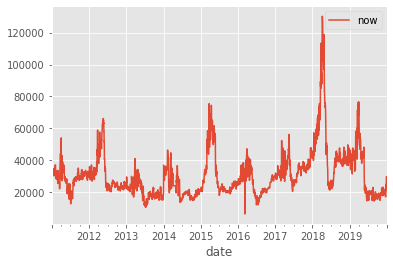

In [415]:
potato_price.plot()

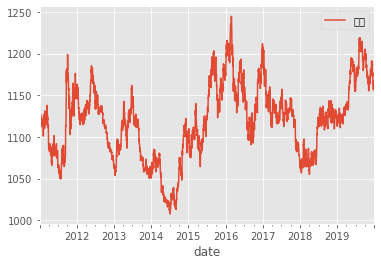

In [416]:
Exchange_Rate.plot()